<a href="https://colab.research.google.com/github/htsnet/automacao-de-negocios/blob/master/Automacao_de_Negocios.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Automação de Negócios

Este projeto tem como objetivo a geração de um modelo que permita a automação de decisões de negócios. 

Baseia-se em uma tabela histórica de simulações de aplicações, com dados fornecidos pela Bolsa de Valores de São Paulo.

As operações são de derivativos de contrato de dólar futuro.

Descrição dos campos:

*   CodOp = Código interno da operação (sem significado)
* Hora Entrada = Hora da compra
* Hora Saida = Hora da venda
* Duração = Intervalo de tempo entre saída e entrada
* Data = Data da operação
* Pentrada = Preço do papel no momento da compra
* Psaida = Preço do papel no momento da venda
* Ganhos = Diferença entre compra e venda, se >= 0
* Perdas = Diferença entre compra e venda, se < 0
* --> Resultado = Resultado da operação (1 = ganho, 2 = perda)  <-- campo target
* Ganho Trade = 
* K entra = 
* K Saida =
* Item 1 = classificador número 1
* Item 2 = classificador número 2
* ...
* Item 77 = classificador número 77

Obs. Todos os classificadores são numéricos e sem valores nulos



In [ ]:
import pandas as pd
import numpy as np
from sklearn.ensemble import ExtraTreesClassifier, RandomForestClassifier, GradientBoostingClassifier
from matplotlib import pyplot as plt
from sklearn.metrics import roc_auc_score
from sklearn.model_selection import train_test_split, cross_val_score, GridSearchCV
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_absolute_error


In [ ]:
#carrega a tabela de dados
#separador de campos = ;
#ponto decimal = ,
historic = pd.read_csv("/content/Amostra Reduzida - Mercado Futuro.csv", sep=";", decimal=",")

In [ ]:
#mostra os primeiros registros
historic.head()

,CodOp,Hora Entrada,Hora Saida,Duração,Data,Pentrada,Psaida,Ganhos,Perdas,Resultado,Ganho Trade,K entra,K Saida,Item 1,Item 2,Item 3,Item 8,Item 12,Item 16,Item 21,Item 23,Item 23-1,Item 27,Item 27-1,Item 31,Item 31-1,Item 35,Item 35-1,Item 39,Item 40,Item 42,Item 44,Item 57,Item 59,Item 62,Item 65,Item 68,Item 71,Item 73,Item 76,Item 77
0,9601,11:00:14,11:14:14,00:13:59,02/01/2019,3876.5,3862.5,0.0,14.0,2,-14.0,120,135,54400,-1800,-11.5,460.0,11400.0,37.5,-1.0,-58,-0.52,-60,-0.80,-74,-0.86,-64,-0.94,33,39,27,44,-11,-8.5,-8.5,-2.0,-2.0,0.0,0.0,2.9,5.4
1,9602,11:01:15,11:14:29,00:13:14,02/01/2019,3874.5,3859.0,0.0,15.5,2,-15.5,120,135,57600,-2200,-13.5,460.0,11400.0,37.5,-4.0,4,0.08,-64,-0.86,-62,-0.86,-66,-0.96,33,37,27,41,-12,-10.5,-11.0,-2.0,-1.5,-0.5,0.0,2.9,5.4
2,9603,11:02:16,11:19:46,00:17:30,02/01/2019,3872.5,3858.0,0.0,14.5,2,-14.5,120,140,57600,-2400,-15.5,460.0,11400.0,37.5,-4.0,-54,-0.82,-68,-0.92,-70,-0.96,-68,-0.96,19,38,25,36,-14,-11.5,-12.5,-2.5,-2.0,-1.0,0.0,2.0,5.4
3,9604,11:03:18,11:19:46,00:16:28,02/01/2019,3872.0,3858.0,0.0,14.0,2,-14.0,125,140,57600,-2400,-16.0,460.0,11400.0,37.5,-1.0,-64,-0.94,-68,-0.92,-62,-0.88,-68,-0.98,18,33,26,35,-14,-12.5,-13.0,-1.5,-1.0,-0.5,0.0,1.8,5.4
4,9605,11:04:39,11:19:46,00:15:07,02/01/2019,3872.0,3858.0,0.0,14.0,2,-14.0,125,140,60800,-2400,-16.0,460.0,11400.0,37.5,-1.0,-64,-0.96,-68,-0.92,-56,-0.80,-68,-0.98,21,37,23,36,-14,-12.5,-12.5,-1.5,-1.5,0.0,0.0,1.6,5.4


In [ ]:
#mostra as dimensões da tabela
historic.shape

(39068, 41)

In [ ]:
#separa o target e retira do dataframe
target = historic['Resultado']
target.shape

(39068,)

In [ ]:
#confirma que todo o target está dentro dos limites de resposta (1 ou 2)
np.unique(target)

array([1, 2])

In [ ]:
#mostra as primeiras linhas
target.head()

0    2
1    2
2    2
3    2
4    2
Name: Resultado, dtype: int64

In [ ]:
#apaga o campo target do dataframe original e outros campos já definidos como não necessários
historic = historic.drop(['Resultado', 'CodOp', 'Hora Entrada', 'Hora Saida', 'Duração', 'Data', 'Pentrada', 'Psaida', 'Ganhos', 'Perdas', 'Ganho Trade', 'K entra', 'K Saida'], axis=1)

In [ ]:
historic.head()

,Item 1,Item 2,Item 3,Item 8,Item 12,Item 16,Item 21,Item 23,Item 23-1,Item 27,Item 27-1,Item 31,Item 31-1,Item 35,Item 35-1,Item 39,Item 40,Item 42,Item 44,Item 57,Item 59,Item 62,Item 65,Item 68,Item 71,Item 73,Item 76,Item 77
0,54400,-1800,-11.5,460.0,11400.0,37.5,-1.0,-58,-0.52,-60,-0.80,-74,-0.86,-64,-0.94,33,39,27,44,-11,-8.5,-8.5,-2.0,-2.0,0.0,0.0,2.9,5.4
1,57600,-2200,-13.5,460.0,11400.0,37.5,-4.0,4,0.08,-64,-0.86,-62,-0.86,-66,-0.96,33,37,27,41,-12,-10.5,-11.0,-2.0,-1.5,-0.5,0.0,2.9,5.4
2,57600,-2400,-15.5,460.0,11400.0,37.5,-4.0,-54,-0.82,-68,-0.92,-70,-0.96,-68,-0.96,19,38,25,36,-14,-11.5,-12.5,-2.5,-2.0,-1.0,0.0,2.0,5.4
3,57600,-2400,-16.0,460.0,11400.0,37.5,-1.0,-64,-0.94,-68,-0.92,-62,-0.88,-68,-0.98,18,33,26,35,-14,-12.5,-13.0,-1.5,-1.0,-0.5,0.0,1.8,5.4
4,60800,-2400,-16.0,460.0,11400.0,37.5,-1.0,-64,-0.96,-68,-0.92,-56,-0.80,-68,-0.98,21,37,23,36,-14,-12.5,-12.5,-1.5,-1.5,0.0,0.0,1.6,5.4


## Análise das variáveis

In [ ]:
#pega o código das variáveis
all_vars = np.array(historic.columns)
all_vars

array(['Item 1', 'Item 2', 'Item 3', 'Item 8', 'Item 12', 'Item 16',
       'Item 21', 'Item 23', 'Item 23-1', 'Item 27', 'Item 27-1',
       'Item 31', 'Item 31-1', 'Item 35', 'Item 35-1', 'Item 39',
       'Item 40', 'Item 42', 'Item 44', 'Item 57', 'Item 59', 'Item 62',
       'Item 65', 'Item 68', 'Item 71', 'Item 73', 'Item 76', 'Item 77'],
      dtype=object)

In [ ]:
#avalia quantas variações de conteúdo tem cada variável e se há linhas vazias
quantidades = pd.DataFrame(columns=['qtde', 'vazias'])

#numéricas
for col in all_vars:
  historic[col] = historic[col].astype('float')
  var = historic.groupby(col).size()
  empty_entries = historic[col].isna().sum()
  quantidades.loc[col] = [var.count(), empty_entries]

print(quantidades.head(50))  

          qtde vazias
Item 1     122      0
Item 2     210      0
Item 3     336      0
Item 8     140      0
Item 12    131      0
Item 16     99      0
Item 21     55      0
Item 23     67      0
Item 23-1  100      0
Item 27     87      0
Item 27-1  101      0
Item 31     88      0
Item 31-1  101      0
Item 35     86      0
Item 35-1  101      0
Item 39     99      0
Item 40     99      0
Item 42     90      0
Item 44     77      0
Item 57    100      0
Item 59    148      0
Item 62    192      0
Item 65    137      0
Item 68    107      0
Item 71    115      0
Item 73    119      0
Item 76    115      0
Item 77    145      0


# Seleção de variáveis baseada em árvore de decisão

In [ ]:
#cria função para avaliar importância
def etc_importances(features_interna, outcome_interna):
  model = ExtraTreesClassifier(n_estimators=200, criterion='entropy', verbose=0)
  model.fit(features_interna, np.array(outcome_interna).ravel())

  importances = model.feature_importances_
  variables = np.array(features_interna.columns)
  indices = np.argsort(importances)[::-1] #tudo, em ordem decrescente
  importances = importances[indices]
  variables = variables[indices]

  return variables, importances

In [ ]:
variables, importances = etc_importances(historic, target)

In [ ]:
#cria função para plotar importâncias x variáveis acumulado
def sum_and_plot_importances(variables, importances):
  sum_importances = pd.DataFrame()
  for i in range(importances.size):
    sum_importance = importances[:(i+1)].sum() #soma todas as colunas anteriores a i
    this_variable = pd.Series([variables[i], sum_importance])
    sum_importances = sum_importances.append(this_variable, ignore_index=True)
  plt.scatter(sum_importances.index, sum_importances.iloc[:,1])
  return sum_importances

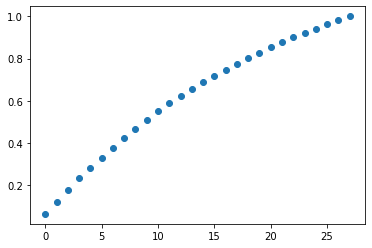

In [ ]:
#plota a importância das variáveis
sum_importances = sum_and_plot_importances(variables, importances)

In [ ]:
sum_importances

,0,1
0,Item 8,0.064813
1,Item 2,0.122128
2,Item 1,0.179431
3,Item 3,0.235074
4,Item 12,0.283119
5,Item 16,0.331020
6,Item 68,0.377826
7,Item 77,0.422510
8,Item 65,0.466996
9,Item 73,0.509509


# Dividindo os dados do dataset para treino e teste

In [ ]:
#cria a função para divisão
def split_datasets(historic, target, test_size=0.2):
  X_train, X_test, y_train, y_test = train_test_split(historic, target,
                                                      test_size=test_size, stratify=target,
                                                      random_state=0)
  y_train, y_test = np.array(y_train).ravel(), np.array(y_test).ravel()
  return X_train, X_test, y_train, y_test

In [ ]:
#faz a divisão
X_train, X_test, y_train, y_test = split_datasets(historic, target)
X_train.shape

(31254, 28)

# Modelagem Preliminar

In [ ]:
#faz a função para mostrar AUC e ROC
padraoCv = 20
def rfc_test(X_train, y_train, n_estimators=100, cv=padraoCv):
  np.random.seed(0)
  rfc = RandomForestClassifier(n_estimators=n_estimators, random_state=0, n_jobs=-1)
  cv_scores = cross_val_score(rfc, X_train, y_train, scoring='roc_auc', cv=cv, n_jobs=-1)
  print('Média dos {} testes: '.format(cv), cv_scores.mean())

In [ ]:
rfc_test(X_train, y_train)

Média dos 20 testes:  0.9856748000898661


In [ ]:
#gera o modelo
model = RandomForestRegressor(n_estimators=300, random_state=0)
#fit modelo
model.fit(X_train, y_train)

RandomForestRegressor(bootstrap=True, ccp_alpha=0.0, criterion='mse',
                      max_depth=None, max_features='auto', max_leaf_nodes=None,
                      max_samples=None, min_impurity_decrease=0.0,
                      min_impurity_split=None, min_samples_leaf=1,
                      min_samples_split=2, min_weight_fraction_leaf=0.0,
                      n_estimators=300, n_jobs=None, oob_score=False,
                      random_state=0, verbose=0, warm_start=False)

In [ ]:
#faz predição com dados de validacao
valoresPrevistos = model.predict(X_test)

#resultado entre 1 e 2, com decimais

0.14671657708386654


In [ ]:
valoresPrevistos

array([1.06666667, 1.04333333, 1.93      , ..., 1.95333333, 1.85666667,
       1.97      ])

In [ ]:
y_test

array([1, 1, 2, ..., 2, 2, 2])

In [ ]:
#lista comparação dos primeiros 50 registros
margemAceitavel = 0.3
for i in range(0, 50):
  if abs(valoresPrevistos[i] - y_test[i]) > margemAceitavel:
    print("Valor previsto: {:.2f} x Valor Real: {}".format(valoresPrevistos[i], y_test[i]), end=' ')
    print(" <<<--- falha: diferença de {:.2f}".format(valoresPrevistos[i] - y_test[i]))
  else:
    print("Valor previsto: {:.2f} x Valor Real: {}".format(valoresPrevistos[i], y_test[i]))


Valor previsto: 1.07 x Valor Real: 1
Valor previsto: 1.04 x Valor Real: 1
Valor previsto: 1.93 x Valor Real: 2
Valor previsto: 1.98 x Valor Real: 2
Valor previsto: 1.89 x Valor Real: 2
Valor previsto: 1.96 x Valor Real: 2
Valor previsto: 1.68 x Valor Real: 2  <<<--- falha: diferença de -0.32
Valor previsto: 1.04 x Valor Real: 1
Valor previsto: 1.98 x Valor Real: 2
Valor previsto: 1.11 x Valor Real: 1
Valor previsto: 1.88 x Valor Real: 1  <<<--- falha: diferença de 0.88
Valor previsto: 1.92 x Valor Real: 2
Valor previsto: 1.78 x Valor Real: 2
Valor previsto: 1.94 x Valor Real: 2
Valor previsto: 1.60 x Valor Real: 1  <<<--- falha: diferença de 0.60
Valor previsto: 1.91 x Valor Real: 2
Valor previsto: 1.79 x Valor Real: 2
Valor previsto: 1.89 x Valor Real: 2
Valor previsto: 1.92 x Valor Real: 2
Valor previsto: 1.90 x Valor Real: 2
Valor previsto: 1.90 x Valor Real: 2
Valor previsto: 1.56 x Valor Real: 1  <<<--- falha: diferença de 0.56
Valor previsto: 1.26 x Valor Real: 1
Valor previsto: 

In [ ]:
#lista quantidade de acertos (considerando um percentual de dúvida)
contaOk = 0
contaNao = 0
for i in range(0, len(y_test)):
  if abs(valoresPrevistos[i] - y_test[i]) < margemAceitavel:
    contaOk += 1
  else:
    contaNao += 1

print("Quantidade de resultados OK: {}\nQuantidade de resultados Não: {}".format(contaOk, contaNao))
print("Percentual de acertos: {:.2f}%".format(contaOk/len(y_test)))

Quantidade de resultados OK: 6894
Quantidade de resultados Não: 920
Percentual de acertos: 0.88%
